In [1]:
import time
import tempfile
import json

from tqdm import tqdm
import pandas as pd
import ray
import click
import torch

from srtml import serve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import seaborn as sns
sns.set(style='whitegrid', palette='muted')


In [2]:
serve.init()

2020-12-06 15:20:06,414	INFO resource_spec.py:212 -- Starting Ray with 328.22 GiB memory available for workers and up to 0.09 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-12-06 15:20:06,800	INFO services.py:1170 -- View the Ray dashboard at localhost:8265


In [3]:
from transformers import BertTokenizer, BertConfig
import torch
from transformers.modeling_bert import BertLayer, BertEmbeddings, BertPooler, BertPreTrainingHeads
from torch.nn import LayerNorm as BertLayerNorm

class Bert(torch.nn.Module):
    def __init__(self, config):
        super(Bert, self).__init__()
        self.embedding_layer = BertEmbeddings(config)
        self.layers = []
        for i in range(config.num_hidden_layers-12):
            self.layers.append(BertLayer(config))

        self.layers = torch.nn.ModuleList(self.layers)
        self.pooling_layer = BertPooler(config)
        self.pre_training_heads_layer = BertPreTrainingHeads(config)
        self.config = config;
        self.apply(self.init_bert_weights)

    def init_bert_weights(self, module):
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding)):
            module.weight.data.normal_(mean=0.0,
                                       std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, torch.nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, input0, input1):
        out0 = input0
        out1 = input1
        out = self.embedding_layer(out0, out1)
        for layer in self.layers:
            out,  = layer(out)
        # out2 = self.pooling_layer(out)
        # out3 = self.pre_training_heads_layer(out, out2)
        return out


class Stage0(torch.nn.Module):
    def __init__(self, config):
        super(Stage0, self).__init__()
        self.embedding_layer = BertEmbeddings(config)
        self.layers = []
#         print(config.num_hidden_layers)
        for i in range(config.num_hidden_layers // 8):
            self.layers.append(BertLayer(config))
        len(self.layers)
        self.layers = torch.nn.ModuleList(self.layers)
        self.config = config
        self.apply(self.init_bert_weights)

    def init_bert_weights(self, module):
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding)):
            module.weight.data.normal_(mean=0.0,
                                       std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, torch.nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, input0, input1):
        out0 = input0
        out1 = input1
        out = self.embedding_layer(out0, out1)
        for layer in self.layers:
            out,  = layer(out)
        return out

class Stage1(torch.nn.Module):
    def __init__(self, config):
        super(Stage1, self).__init__()
        self.layers = []
        for i in range(config.num_hidden_layers // 8):
            self.layers.append(BertLayer(config))
        len(self.layers)
        self.layers = torch.nn.ModuleList(self.layers)
#         self.pooling_layer = BertPooler(config)
#         self.pre_training_heads_layer = BertPreTrainingHeads(config)
        self.config = config
        self.apply(self.init_bert_weights)

    def init_bert_weights(self, module):
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding)):
            module.weight.data.normal_(mean=0.0,
                                       std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, torch.nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, input0):
        out = input0
        for layer in self.layers:
            out,  = layer(out)
#         out2 = self.pooling_layer(out)
#         out3 = self.pre_training_heads_layer(out, out2)
        return out

class Stage2(torch.nn.Module):
    def __init__(self, config):
        super(Stage2, self).__init__()
        self.layers = []
        for i in range(config.num_hidden_layers // 8):
            self.layers.append(BertLayer(config))
        len(self.layers)
        self.layers = torch.nn.ModuleList(self.layers)
#         self.pooling_layer = BertPooler(config)
#         self.pre_training_heads_layer = BertPreTrainingHeads(config)
        self.config = config
        self.apply(self.init_bert_weights)

    def init_bert_weights(self, module):
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding)):
            module.weight.data.normal_(mean=0.0,
                                       std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, torch.nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, input0):
        out = input0
        for layer in self.layers:
            out,  = layer(out)
#         out2 = self.pooling_layer(out)
#         out3 = self.pre_training_heads_layer(out, out2)
        return out

class Stage3(torch.nn.Module):
    def __init__(self, config):
        super(Stage3, self).__init__()
        self.layers = []
        for i in range(config.num_hidden_layers // 8):
            self.layers.append(BertLayer(config))
        len(self.layers)
        self.layers = torch.nn.ModuleList(self.layers)
        self.pooling_layer = BertPooler(config)
        self.pre_training_heads_layer = BertPreTrainingHeads(config)
        self.config = config
        self.apply(self.init_bert_weights)

    def init_bert_weights(self, module):
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding)):
            module.weight.data.normal_(mean=0.0,
                                       std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, torch.nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, input0):
        out = input0
        for layer in self.layers:
            out,  = layer(out)
#         out2 = self.pooling_layer(out)
#         out3 = self.pre_training_heads_layer(out, out2)
        return out

##################################################################################################




In [4]:
return_type = 'torch'
batch_size = 1
def noop(*args, **kwargs):
    bs = serve.context.batch_size
    time.sleep(0.1)
#     assert (
#         bs == batch_size
#     ), f"worker received {batch_size} which is not what expected {batch_size}"
    result = ""
    
    if return_type == "torch":
        result = torch.zeros((3, 224, 224))

    if bs is None:  # No batching
        return result
    else:
        return [result] * bs

noop = serve.accept_batch(noop)

In [5]:
bert_config = BertConfig.from_pretrained('bert-large-uncased')

def bert(*args, data, **kwargs):

    model = Bert(bert_config)
    model.cuda()
    input0 = torch.stack([item['input_ids'][0] for item in data])
    input1 = torch.stack([item['attention_mask'][0] for item in data])

    input0 = input0.cuda()
    input1 = input1.cuda()
    outputs = model(input0, input1)
    res = list(outputs.cpu().unbind())
    return res


def stage0(*args, data, **kwargs):

    model = Stage0(bert_config)
    model.cuda()
    input0 = torch.stack([item['input_ids'][0] for item in data])
    input1 = torch.stack([item['attention_mask'][0] for item in data])

    input0 = input0.cuda()
    input1 = input1.cuda()
    outputs = model(input0, input1)
    res = list(outputs.cpu().unbind())
    return res

def stage1(*args, data, **kwargs):
    model = Stage1(bert_config)
    model.cuda()
#     print('stage1: ', data[0].shape)
    input0 = torch.stack(data)
    input0 = input0.cuda()
    outputs = model(input0)
    res = list(outputs.cpu().unbind())
    return res

def stage2(*args, data, **kwargs):
    model = Stage2(bert_config)
    model.cuda()
#     print('stage2: ', data[0].shape)
    input0 = torch.stack(data)
    input0 = input0.cuda()
    outputs = model(input0)
    res = list(outputs.cpu().unbind())
    return res

def stage3(*args, data, **kwargs):
    model = Stage3(bert_config)
    model.cuda()
#     print('stage3: ', data[0].shape)
    input0 = torch.stack(data)
    input0 = input0.cuda()
    outputs = model(input0)
    res = list(outputs.cpu().unbind())
    return res

bert = serve.accept_batch(bert)
stage3 = serve.accept_batch(stage3)
stage2 = serve.accept_batch(stage2)
stage1 = serve.accept_batch(stage1)
stage0 = serve.accept_batch(stage0)

In [6]:

with serve.using_router("noop"):
    serve.create_endpoint("noop", "/noop")
    config = serve.BackendConfig(max_batch_size=batch_size)
#     config = serve.BackendConfig()
    serve.create_backend(noop, "noop", backend_config=config)
    serve.link("noop", "noop")
    handle = serve.get_handle("noop")

num_backends = 4
backend = [stage0, stage1, stage2, stage3]
handle = [None]*num_backends

for i in range(num_backends):
    router_name = 'stage' + str(i)
    with serve.using_router(router_name):
        serve.create_endpoint(router_name, '/'+router_name)
        config = serve.BackendConfig(max_batch_size=batch_size, num_gpus=1)
    #     config = serve.BackendConfig()
        serve.create_backend(backend[i], router_name, backend_config=config)
        serve.link(router_name, router_name)
        handle[i] = serve.get_handle(router_name)

# with serve.using_router("noop2"):
#     serve.create_endpoint("noop2", "/noop2")
#     config = serve.BackendConfig(max_batch_size=batch_size, num_gpus=1)
# #     config = serve.BackendConfig()
#     serve.create_backend(stage1, "noop2", backend_config=config)
#     serve.link("noop2", "noop2")
#     handle2 = serve.get_handle("noop2")

num_queries = 30
num_warmups = 20

In [7]:
latency = []
txt = 'Debugging'
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
encoded = tokenizer(text=txt, add_special_tokens=True,  # Add [CLS] and [SEP]
                         max_length = 64,  # maximum length of a sentence
                         padding='max_length',  # Add [PAD]s
                         return_attention_mask = True,  # Generate the attention mask
                         return_tensors = 'pt')

prepoc_dummy_kwarg = {"data": [txt]}

for i in tqdm(range(num_warmups + num_queries)):
    if i == num_warmups:
        serve.clear_trace()
    oids = []
    start = time.perf_counter()
    x = None
    if not batch_size:
        ray.get(
            # This is how to pass a higher level metadata to the tracing
            # context
            handle.options(
                tracing_metadata={"pipeline-id": i}
            ).remote()
        )
    else:
#         r = handle1.options(tracing_metadata={"pipeline-id": i}).remote(
#                 data=encoded
#             )
#         r = handle2.options(tracing_metadata={"pipeline-id": i}).remote(
#                  data=r  # torch tensor
#             )
#         oids.append(r)

#         x = ray.get(handle1.enqueue_batch(val=ray.get(handle.enqueue_batch(val=[1] * batch_size))))
        #x = ray.get(handle2.options(tracing_metadata={"pipeline-id": i}).remote(data=ray.get(handle1.options(tracing_metadata={"pipeline-id": i}).remote(data = encoded))))
#         ray.get([handle.remote() for _ in range(batch_size)])
#         print(x)
#         x1 = ray.get(handle[0].options(tracing_metadata={'pipeline-id':i}).remote(data=encoded))
#         x2 = ray.get(handle[1].options(tracing_metadata={'pipeline-id':i}).remote(data=ray.get(handle[0].options(tracing_metadata={'pipeline-id':i}).remote(data=encoded))))
#         x3 = ray.get(handle[2].options(tracing_metadata={'pipeline-id':i}).remote(data=ray.get(handle[1].options(tracing_metadata={'pipeline-id':i}).remote(data=ray.get(handle[0].options(tracing_metadata={'pipeline-id':i}).remote(data=encoded))))))
#         x4 = ray.get(handle[1].options(tracing_metadata={"pipeline-id": i}).remote(data=ray.get(handle[0].options(tracing_metadata={"pipeline-id": i}).remote(data = encoded))))
        x4 = ray.get(handle[3].options(tracing_metadata={'pipeline-id':i}).remote(data=ray.get(handle[2].options(tracing_metadata={'pipeline-id':i}).remote(data=ray.get(handle[1].options(tracing_metadata={'pipeline-id':i}).remote(data=ray.get(handle[0].options(tracing_metadata={'pipeline-id':i}).remote(data=encoded))))))))
#     x = ray.wait(oids, len(oids))
    end = time.perf_counter()
    latency.append(end - start)
    
# Remove initial samples
latency = latency[num_warmups:]

100%|██████████| 12/12 [00:43<00:00,  3.65s/it]


In [8]:

series = pd.Series(latency) * 1000
print("Latency for single noop backend (ms)")
print(series.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

Latency for single noop backend (ms)
count       2.000000
mean     2631.009342
std         1.026083
min      2630.283792
50%      2631.009342
90%      2631.589783
95%      2631.662338
99%      2631.720382
max      2631.734893
dtype: float64


In [9]:
trace_file = 'trace.json'
with open(trace_file, "w") as f:
    json.dump(serve.get_trace(), f)
print(f"trace file written to {trace_file}")

trace file written to trace.json


In [10]:
data = serve.get_trace()
df = pd.DataFrame(data['metadata'])
df = df.transpose()
print(df)
df = pd.DataFrame(data['traces'])
df = df.sort_values(['query_id', 'event', 'time_us']).reset_index(drop=True)

   endpoint pipeline-id backend batch_id
11   stage3          10  stage3       10
12   stage3          11  stage3       11


In [11]:
df = pd.DataFrame(data['traces'])
df = df.sort_values(['query_id', 'event', 'time_us']).reset_index(drop=True)
df1 = pd.DataFrame()
c = 0
prev = None
for a,q,i in df.itertuples(index=False):
#     print(q)
    if i == prev:
        c+=1
        df1 = df1.append({'query_id': str(q), 'event': i+'_'+str(c)}, ignore_index = True)
    else:
        c = 0
        df1 = df1.append({'query_id': str(q), 'event': i+'_'+str(c)}, ignore_index = True)
        prev = i
# df.loc[df['query_id'] == 514]
# df.head(20)
df1.head(20)
df[['event', 'query_id']] = df1
df.head(50)
# df = df.sort_values('time_us')
# df.head(20)


,time_us,query_id,event
0,1607139055992979,11,router_dequeue_0
1,1607139056854332,11,router_dequeue_1
2,1607139057293788,11,router_dequeue_2
3,1607139057733020,11,router_dequeue_3
4,1607139055991522,11,router_enqueue_0
5,1607139056852903,11,router_enqueue_1
6,1607139057292253,11,router_enqueue_2
7,1607139057731575,11,router_enqueue_3
8,1607139056846856,11,router_recv_result_0
9,1607139057285660,11,router_recv_result_1


In [12]:
df = df.pivot(index='query_id', columns="event").droplevel(0,axis=1)

In [13]:
event_ordering = [
    'router_enqueue',
    "router_dequeue",
    "worker_start",
    "worker_done",
    "router_recv_result"
]
new_event_ordering = []
for i in range(num_backends):
    for event in event_ordering:
          new_event_ordering.append(event+ '_' + str(i)) 
event_ordering = new_event_ordering
series = {}
for e_start, e_end in zip(event_ordering, event_ordering[1:]):
    series[f"{e_start}->{e_end}"] = (df[e_end] - df[e_start])/1000
diff_df = pd.DataFrame(series)

diff_df.to_csv('data.csv')
print(diff_df.mean(axis=0))
# diff_df

router_enqueue_0->router_dequeue_0          1.4410
router_dequeue_0->worker_start_0            1.4835
worker_start_0->worker_done_0             843.9900
worker_done_0->router_recv_result_0         2.7855
router_recv_result_0->router_enqueue_1      6.2210
router_enqueue_1->router_dequeue_1          1.4425
router_dequeue_1->worker_start_1            1.8200
worker_start_1->worker_done_1             429.7140
worker_done_1->router_recv_result_1         5.2055
router_recv_result_1->router_enqueue_2      6.4990
router_enqueue_2->router_dequeue_2          1.5390
router_dequeue_2->worker_start_2            1.9500
worker_start_2->worker_done_2             426.9510
worker_done_2->router_recv_result_2         2.5495
router_recv_result_2->router_enqueue_3      6.2630
router_enqueue_3->router_dequeue_3          1.4295
router_dequeue_3->worker_start_3            2.2465
worker_start_3->worker_done_3             878.8580
worker_done_3->router_recv_result_3         2.6415
dtype: float64


/nethome/gkakkar7/miniconda3/envs/srtml-exp/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nethome/gkakkar7/miniconda3/envs/srtml-exp/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nethome/gkakkar7/miniconda3/envs/srtml-exp/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

Text(0.5, 0, 'us')

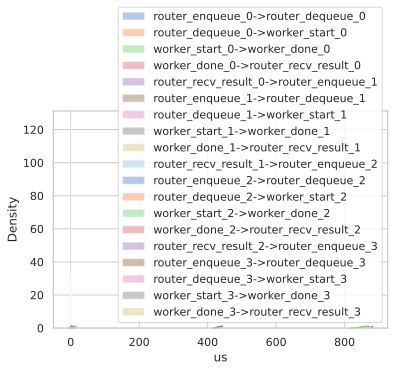

In [14]:
for name, s in diff_df.T.iterrows():
    sns.distplot(s, label=name, kde_kws={"cumulative": True})
plt.legend()
plt.xlabel("us")